# Assignment 1

Due Friday 5th August 23:59

## Assignment Outline

### Explore data
* Inspect the shape and types of data
* Visualization
* Value counts
### Clean data
* null
* nonsensical 
### Understand data
* Find relationships
    * Correlation
    * Mean house price against categorical levels
* Feature engineering
    * livingArea and bedrooms variable?
    * lotSize and landValue variable?


In [301]:
import csv
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

## Import CSV

In [302]:


with open("data.csv", 'r') as data:
    header = csv.reader(data).__next__()

# remove unnamed row.
houses = pd.read_csv('data.csv', usecols=header[1:])

## Splitting the data

In [303]:

X = houses.drop(["price"], axis = 1) # indepedent features
y = houses["price"].copy          # dependent variable

train_set, test_set = train_test_split(houses, test_size=0.2, random_state=0)


In [304]:
train_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1649,153000,0.11,16,2900,1480,40,2,0,2.5,4,hot air,gas,public/commercial,No,No,No
1465,223000,0.33,18,27000,1360,40,3,1,1.5,8,electric,electric,public/commercial,No,No,No
361,178500,1.00,12,32000,1952,71,3,2,2.0,9,hot air,oil,septic,No,No,No
315,168500,0.44,34,31800,1586,64,3,1,1.5,7,hot air,gas,public/commercial,No,No,No
1372,167500,0.16,18,15100,1492,40,3,0,2.5,6,electric,electric,public/commercial,No,No,No


In [305]:
test_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1318,229900,0.44,7,24200,1328,64,3,1,2.5,8,hot air,gas,public/commercial,No,No,No
124,158000,0.52,0,4400,2098,44,3,0,2.0,7,hot air,gas,septic,No,Yes,Yes
648,367500,0.27,2,78200,2205,57,3,1,2.5,10,hot air,gas,public/commercial,No,No,Yes
249,128850,0.92,16,5500,824,45,3,0,1.5,5,electric,electric,septic,No,No,No
1599,290000,0.61,34,32300,2728,64,4,1,2.5,10,hot water/steam,gas,public/commercial,No,No,No


## Explore the Training Set

There are 1105 rows and 16 features of the training set. There are no missing values.

In [306]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1649 to 684
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1382 non-null   int64  
 1   lotSize          1382 non-null   float64
 2   age              1382 non-null   int64  
 3   landValue        1382 non-null   int64  
 4   livingArea       1382 non-null   int64  
 5   pctCollege       1382 non-null   int64  
 6   bedrooms         1382 non-null   int64  
 7   fireplaces       1382 non-null   int64  
 8   bathrooms        1382 non-null   float64
 9   rooms            1382 non-null   int64  
 10  heating          1382 non-null   object 
 11  fuel             1382 non-null   object 
 12  sewer            1382 non-null   object 
 13  waterfront       1382 non-null   object 
 14  newConstruction  1382 non-null   object 
 15  centralAir       1382 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 183.5+ KB

#### Analyze Distributions

livingArea[5], pctCollege[6], bedrooms[7], fireplaces[8], bathrooms[9] and rooms[10] are approximately normally distributed.
Price[1], lotSize[2], age[3], landValue[4] are right skewed and could use normalizing.

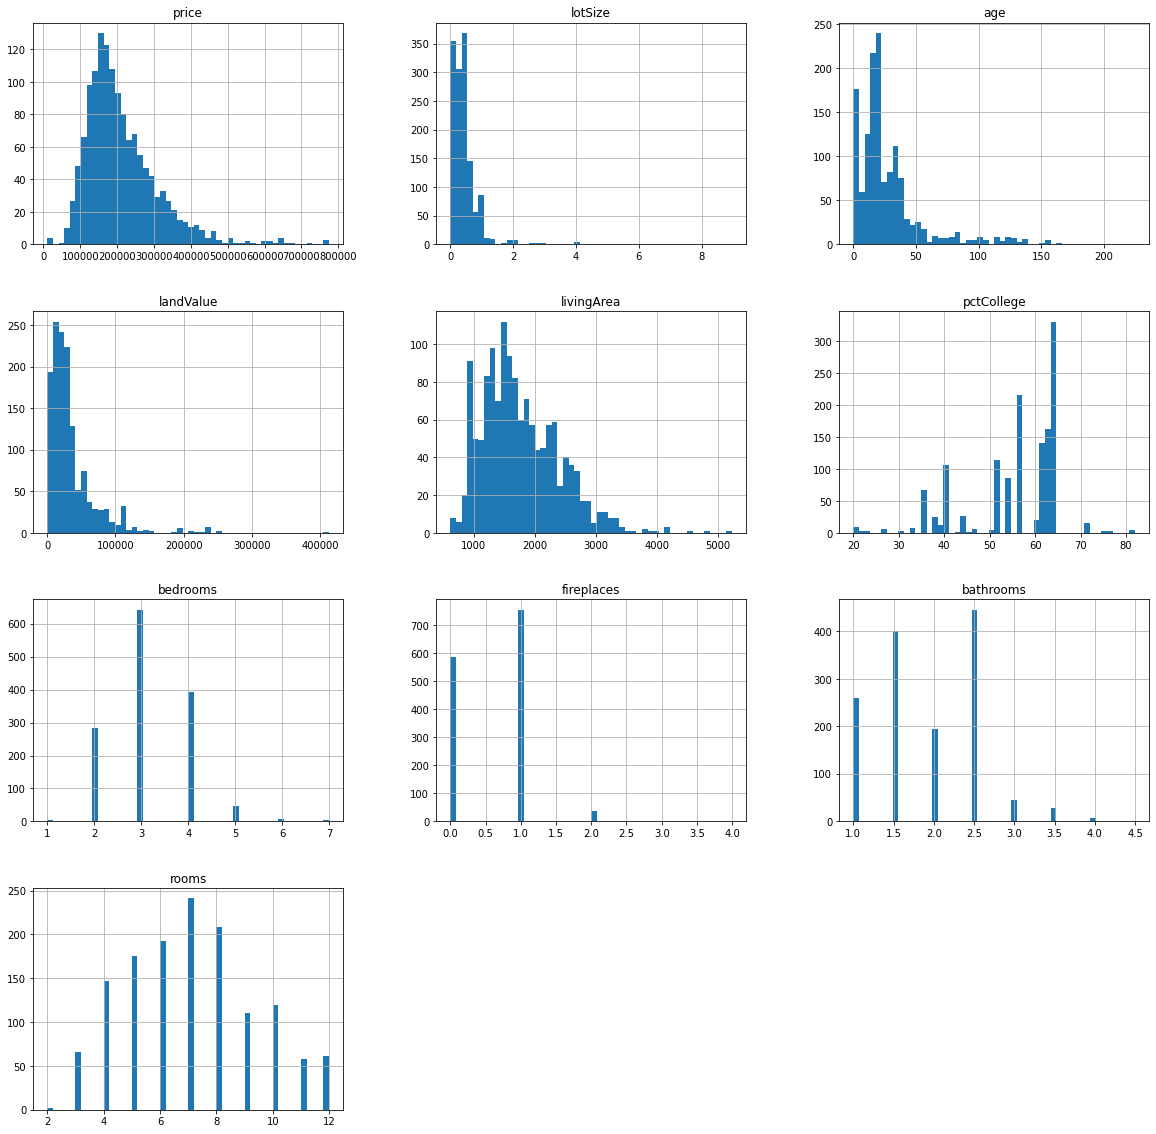

In [307]:
train_set.hist(bins = 50, figsize = (20,20))
fig = plt.gcf() 
fig.savefig('hist.pdf', bbox_inches = 'tight')

Below emphasises the right tail skew in features 1, 2, 3 and 4. They all have a disproportionately large spread and very large values.


In [308]:
train_set.describe()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,211977.407381,0.495904,27.996382,35266.005789,1758.619392,55.685962,3.164978,0.610709,1.904848,7.049204
std,99608.842830,0.661244,29.182973,36616.276086,625.841288,10.316558,0.834791,0.564815,0.661465,2.330519
min,10300.000000,0.000000,0.000000,300.000000,616.000000,20.000000,1.000000,0.000000,1.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1297.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,188900.000000,0.370000,19.000000,25100.000000,1643.000000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259106.500000,0.540000,34.000000,40875.000000,2179.000000,64.000000,4.000000,1.000000,2.500000,9.000000
max,775000.000000,8.970000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


#### Understand Correlation

livingArea is correlated with multiple other features which may have a negative affect on our model. Bedrooms and rooms may also affect our model negatively. I would like to see how the model performs both with and without these features.

<AxesSubplot:>

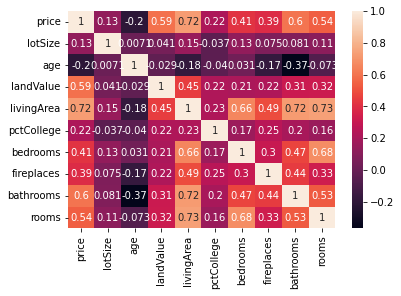

In [309]:
sns.heatmap(train_set.corr(), annot=True)

#### Understand Categorical Data

It may be useful to see how the frequency of the categorical levels compare.

In [310]:


my_selector = selector(dtype_include=object)
categorical = my_selector(train_set)

# print the levels of the categorical variables
def levels(df, features):
    [print(feature, df[feature].unique()) for feature in features]

levels(train_set, categorical)


heating ['hot air' 'electric' 'hot water/steam']
fuel ['gas' 'electric' 'oil']
sewer ['public/commercial' 'septic' 'none']
waterfront ['No' 'Yes']
newConstruction ['No' 'Yes']
centralAir ['No' 'Yes']


Barcharts are created to see how these levels balance.

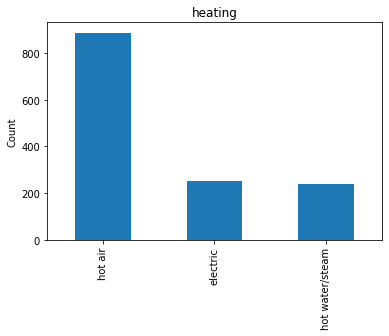

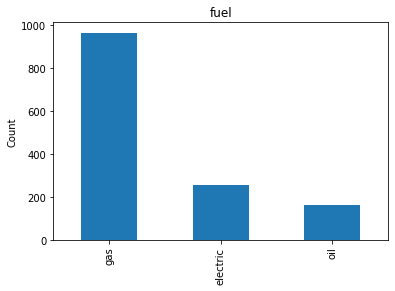

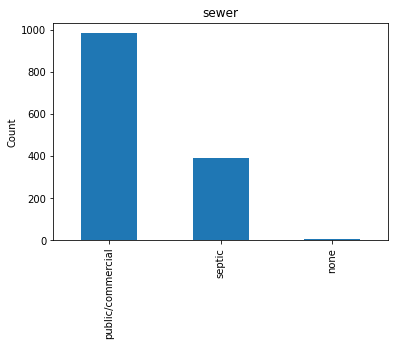

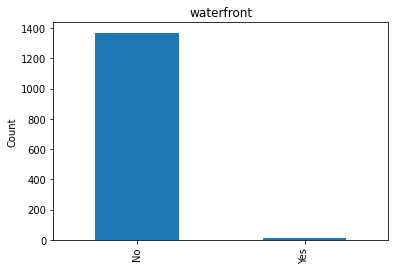

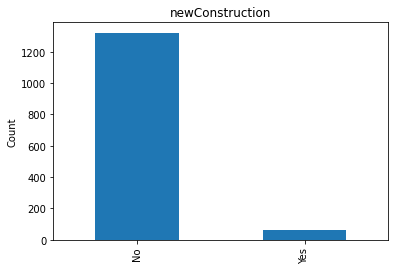

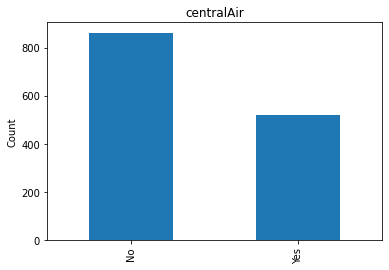

In [311]:
def plot_categorical(df, features):
    for feature in features:
        df[feature].value_counts().plot(kind='bar')
        plt.title(feature)
        plt.ylabel('Count')
        plt.show()
plot_categorical(train_set, categorical)



Compare categorical levels with their mean price

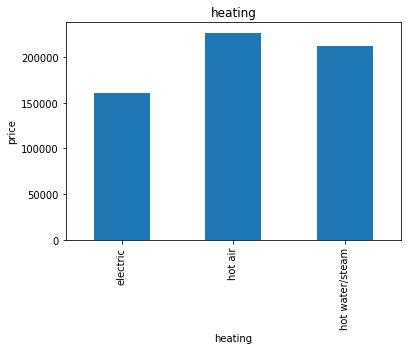

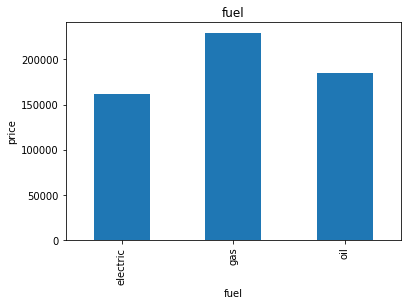

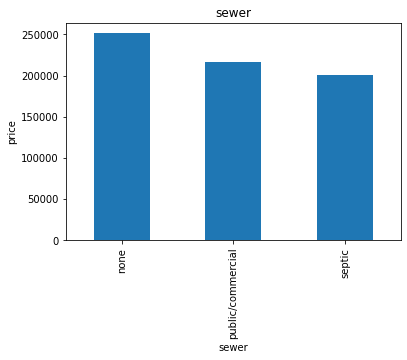

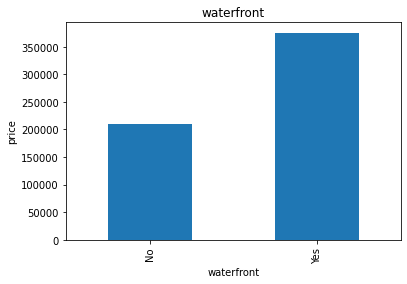

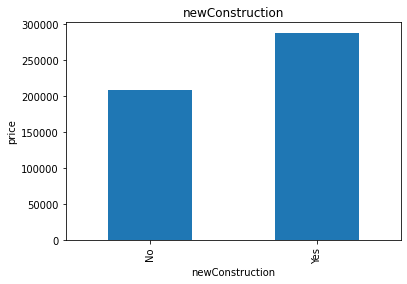

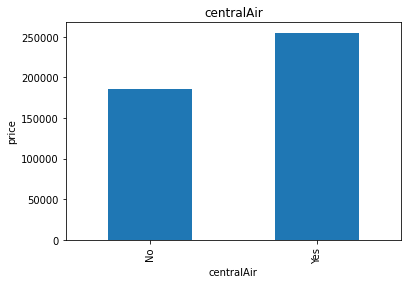

In [312]:
def compare_categorical(df, features, target):
    for feature in features:
        df.groupby(feature).mean()[target].plot(kind='bar')
        plt.title(feature)
        plt.ylabel(target)
        plt.show()
compare_categorical(train_set, categorical, 'price')


## Pipeline

#### Dropping Labels

Separate the predictors and the labels since we don't
necessarily want to apply the same transformations
to the predictors and the target values.

In [313]:
X_train = train_set.drop("price", axis=1) # drop labels for training set
y_train = train_set["price"].copy()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

### Transform Data

#### Get different types of data

In [410]:
# splits the data into categorical and numerical features
def split_columns(df):
      my_selector = selector(dtype_include=int)
      numerical_int = my_selector(df)
      my_selector = selector(dtype_include=float)
      numerical_float = my_selector(df)
      my_selector = selector(dtype_include=object)
      categorical = my_selector(df)
      return numerical_int, numerical_float, categorical

numerical_int, numerical_float, nominal = split_columns(X_train)
print("Features length:", len(X_train.columns), "\nCollected data: ",
      len(numerical_int) + len(nominal) + len(numerical_float))
numerical = numerical_int + numerical_float
print("Numerical: ", len(numerical))
print("Nominal:",len(nominal))


Features length: 15 
Collected data:  15
Numerical:  9
Nominal: 6


#### Make Pipelines

We have all the data separated into their corresponding groups. Note that all of our categorical variables are nominal, so we do not need an ordinal pipeline.

In [315]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())])
# one hot encoder to convert nominal data into binary data.
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])


#### Create pre-processor and Model

Create the column transformer to simplify our data into all numerical

In [316]:
preprocessor = ColumnTransformer([
    ('numerical_transformer', numerical_pipeline, numerical),
    ('nominal_transformer', nominal_pipeline, nominal)
])
preprocessor

ColumnTransformer(transformers=[('numerical_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'landValue', 'livingArea',
                                  'pctCollege', 'bedrooms', 'fireplaces',
                                  'rooms', 'lotSize', 'bathrooms']),
                                ('nominal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['heating', 'fuel', 'sewer', 'waterfront',
                                  'newConstruction', 'centralAir'])])

Our data is ready for a model to fit to it. Transform our data into all numerical, perform scaling and fill in missing values. Afterward fit the training data to a linear regression model.

In [382]:
# transform columns and fit the model
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'landValue',
                                                   'livingArea', 'pctCollege',
                                                   'bedrooms', 'fireplaces',
                                                   'rooms', 'lotSize',
                                                   'bathrooms']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['heating', 'fuel', 'sewer',
                                                   'waterfront',
                                                   'newConstruction',
                                                   'centralAir'])])),
                ('regressor', LinearRegression())])

## Tune Parameters

### Grid Search CV

In [361]:
# lr_model.get_params().keys()
param_grid = [
    {'regressor__fit_intercept': [True, False],
     'regressor__copy_X': [True, False],
     'regressor__n_jobs': [1, -1],
     'regressor__positive': [True, False]}
]
grid_search = GridSearchCV(lr_model, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'landValue',
                                                                          'livingArea',
                                                                          'pctCollege',
                                                                          'bedrooms',
                                                                          'fireplaces',
                                                                          'rooms',
                                                                          'lotSize',
                                                                          'bathrooms']),
                                                                        ('nominal_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleIm...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heating',
                                                                          'fuel',
                                                                          'sewer',
                                                                          'waterfront',
                                                                          'newConstruction',
                                                                          'centralAir'])])),
                                       ('regressor', LinearRegression())]),
             param_grid=[{'regressor__copy_X': [True, False],
                          'regressor__fit_intercept': [True, False],
                          'regressor__n_jobs': [1, -1],
                          'regressor__positive': [True, False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [362]:
grid_search.best_params_

{'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': 1,
 'regressor__positive': False}

In [366]:
np.sqrt(abs(grid_search.best_score_))

59300.91207652445

In [392]:
grid_search.best_estimator_.named_steps['regressor']

LinearRegression(n_jobs=1)

### Random Search CV

## Make Predictions & Evaluate

### Training Set

#### Predict with Linear Regression

In [408]:
def metrics(model, predictions, X, y):
    RMSE = np.sqrt(mean_squared_error(y, predictions))
    MAPE = (np.mean(np.abs((y - predictions) / y))) * 100
    R_squared = model.score(X, y)
    return pd.DataFrame({"RMSE": RMSE, "MAPE": MAPE, "R^2": R_squared}, index = ["Linear Regression"])
    
lr_model.fit(X_train, y_train)
train_predictions = lr_model.predict(X_train)
metrics(lr_model, train_predictions, X_train, y_train)


,RMSE,MAPE,R^2
Linear Regression,58001.634594,22.889198,0.660688


In [320]:
y_train_predicted = lr_model.fit(X_train, y_train).predict(X_train)

# display actual vs predicted and the residuals
def summarize_results(y_train, y_train_predict):
    return pd.DataFrame({'Actual': y_train, 'Predicted': y_train_predict,
                        'Difference': abs(y_train - y_train_predict),
                        'Difference_percent': (abs(y_train - y_train_predict)/y_train*100)})

results = summarize_results(y_train, y_train_predicted)
print("On average, our model has", round((results['Difference_percent'].mean()), 4), '% error (MAPE)')
results.sample(5)

On average, our model has 22.8892 % error (MAPE)


,Actual,Predicted,Difference,Difference_percent
1586,360000,324855.786831,35144.213169,9.762281
813,245000,206686.232841,38313.767159,15.638272
1370,147423,112710.036258,34712.963742,23.546505
1094,275000,222885.204379,52114.795621,18.950835
443,189100,200767.722817,11667.722817,6.170134


#### Visualizing Predictions vs Actual

The model tends to under-estimate for higher values. This is typical when the target value does not follow a normal distribution. Hence, we should normalize price.

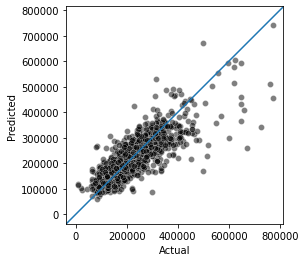

In [321]:
def plot_residuals(results):
    sns.scatterplot(y='Predicted', x='Actual', data=results,
                      color="black", alpha=0.5)
    plt.axline((0, 0), slope=1, label="Perfect fit")
    plt.axis('square')
    plt.show()
plot_residuals(results)

#### Scale Target variable and check predictions again

In [433]:
quantile_transformer = QuantileTransformer(n_quantiles=1000, output_distribution="normal")
model_transformed_target = TransformedTargetRegressor(regressor=lr_model,
                                                      transformer=quantile_transformer)
model_transformed_target.fit(X_train, y_train)
y_train_predicted = model_transformed_target.predict(X_train)

Once the model get scaled, it has about MAPE, but R^2 is about 0.05 worse and RMSE is about 5000 worse. Hence, we'll try not scaling the data.

In [434]:
metrics(model_transformed_target, y_train_predicted, X_train, y_train)

,RMSE,MAPE,R^2
Linear Regression,63405.385403,22.359019,0.594519


In [435]:
results_adjusted = summarize_results(y_train, y_train_predicted)
results_adjusted.sample(5)

,Actual,Predicted,Difference,Difference_percent
1459,148400,124000.000000,24400.000000,16.442049
372,324000,343214.595703,19214.595703,5.930431
266,167000,145000.000000,22000.000000,13.173653
1302,209000,175000.000000,34000.000000,16.267943
1007,159900,159766.776927,133.223073,0.083316


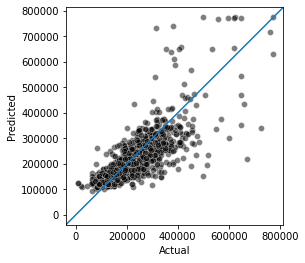

In [436]:
plot_residuals(results_adjusted)

### Test Set

#### Predict with Linear Regression

In [446]:
lr_model.fit(X_train, y_train)
y_test_predicted = lr_model.predict(X_test)
metrics(lr_model, y_test_predicted, X_test, y_test)

,RMSE,MAPE,R^2
Linear Regression,58315.087556,34.341188,0.612146


In [447]:
results_test = summarize_results(y_test, y_test_predicted)
results_test.sample(5)

,Actual,Predicted,Difference,Difference_percent
1362,287989,344346.151557,56357.151557,19.569203
642,339000,295725.658847,43274.341153,12.765292
512,165000,179253.597217,14253.597217,8.638544
522,138000,158826.430412,20826.430412,15.091616
593,135000,187443.824251,52443.824251,38.847277


### Visualizing predictions vs actual

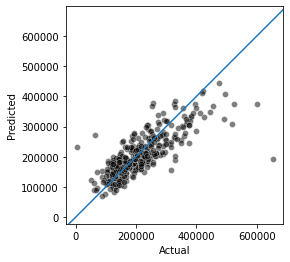

In [448]:
plot_residuals(results_test)

In [432]:
model_transformed_target.fit(X_test, y_test)
y_test_predicted = model_transformed_target.predict(X_test)

c:\Python310\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (346). n_quantiles is set to n_samples.
  warnings.warn(


## Support Vector Regressor

#### Cross Validation

Estimate the expected level of fit of the model using cross validation.

In [ ]:
cv_results = cross_validate(lr_model, X_train, y_train, 
                            scoring = 'neg_mean_squared_error', cv = 5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

The mean cross-validation RMSE is:  59039.5737 +/- 5561.1973


#### Support Vector Regressor

Fit our data to a support vector regressor to make predictions. Use RMSE again to evaluate, then cross validate and see how it compares to linear regression.

In [ ]:
def fit_predict_evaluate(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predict)))
    cv_results = cross_validate(model, X_train, y_train, 
                                scoring = 'neg_mean_squared_error', cv = 5)
    scores = np.sqrt(-cv_results["test_score"])
    print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")
    
fit_predict_evaluate(lr_model, X_train, y_train)

RMSE on the training set: 58001.6346
The mean cross-validation RMSE is:  59039.5737 +/- 5561.1973


In [ ]:

svm_model = Pipeline([
 ('preprocessor', preprocessor),
 ('regressor', SVR())
])
svm_model.fit(X_train, y_train)
y_train_predicted = svm_model.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))
cv_results = cross_validate(svm_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")


RMSE on the training set: 102140.8791
The mean cross-validation RMSE is:  101823.0893 +/- 9748.5110


In [ ]:

param_grid = [
 {'regressor__C': [1000, 10000, 100000, 1000000],
 'regressor__gamma': [0.1, 1, 10, 'scale', 'auto']},
]
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train);



In [ ]:
grid_search.best_params_

{'regressor__C': 1000000, 'regressor__gamma': 'auto'}

In [ ]:
y_train_predicted = grid_search.best_estimator_.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))


RMSE on the training set: 44483.9022


In [ ]:
cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

The mean cross-validation RMSE is:  59884.0594 +/- 7617.6770


In [ ]:
y_test_predicted = lr_model.predict(X_test)
print("RMSE of the LinearRegression model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))

RMSE of the LinearRegression model on the test set: 58315.0876


In [ ]:
y_test_predicted = svm_model.predict(X_test)
print("RMSE of the SVR model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))


RMSE of the SVR model on the test set: 96359.8000


In [ ]:
y_test_predicted = grid_search.best_estimator_.predict(X_test)
print("RMSE of the optimized SVR model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))

RMSE of the optimized SVR model on the test set: 59525.3867
